# Definition of the Models

In [1]:
import sklearn
import numpy as np
import pandas as pd
import time
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
import math 

##### Opening the csv generated by the preprocessing

In [2]:
path='/Users/Pierr/OneDrive/Documents/CentraleSupelec/MLAirBnb/train_airbnb_berlin_Preprocessed.csv'
my_sep,my_encoding=',','utf-8'
df=pd.read_csv(path,sep=my_sep,encoding=my_encoding)

##### Creating X and y

In [3]:
X=df.drop(columns=['price'])
y=df['price'].copy()

##### Split X and Y into Train and Validation with Ratios 80:20

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### GridSearch Cross Validation on various models in order to see the score of each and we select the two bests

In [55]:
lr=LinearRegression()
dt=DecisionTreeRegressor()
rf=RandomForestRegressor()
svm=SVR()
xgboost=xgb.XGBRegressor()
adab=AdaBoostRegressor()
class_list=[lr, dt,rf,svm,xgboost,adab]
for model in class_list:
        start = time.time()
        grid = GridSearchCV(estimator=model, param_grid={}, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1,verbose=3)
        grid.fit(X_train, y_train)
        end = time.time()
        print(model, '\n', -grid.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
LinearRegression() 
 28.629875324027978
Fitting 3 folds for each of 1 candidates, totalling 3 fits
DecisionTreeRegressor() 
 40.12468018073614
Fitting 3 folds for each of 1 candidates, totalling 3 fits
RandomForestRegressor() 
 28.705255521034346
Fitting 3 folds for each of 1 candidates, totalling 3 fits
SVR() 
 41.057763482915355
Fitting 3 folds for each of 1 candidates, totalling 3 fits
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             

***XGBoost** and **Random Forest** are the two best options here, we are going to use a GridSearch with params this time to train them*

##### Trying Different combinations and computations of the hyperparameters with XGBoost to get the best hyperparameters

In [56]:
params = { 'max_depth': [3, 6, 8, 10, 12],
           'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.15],
           'n_estimators': [100, 250, 500, 600, 800, 1000],
           'colsample_bytree': [0.1, 0.2, 0.3]}

xgbr = xgb.XGBRegressor()
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_root_mean_squared_error', 
                   verbose=1)
clf.fit(X_train, y_train)

best_params_xgb = clf.best_params_
score_xgb = clf.best_score_

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


In [57]:
print('Best params: ', best_params_xgb, '\n', 'Best score: ', -score_xgb)

Best params:  {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800} 
 Best score:  27.74921139214033


In [ ]:
df_plot_grid_xgb = pd.DataFrame(clf.cv_results_)

Text(0, 0.5, 'mean_test_score')

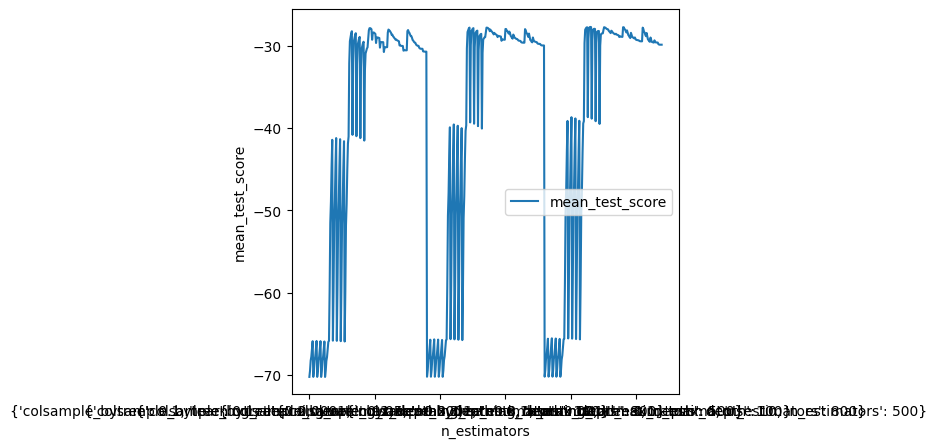

In [59]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()
df_plot_grid_xgb.set_index("params")[["mean_test_score"]].plot(ax=ax)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)
ax.set_xlabel("n_estimators")
ax.set_ylabel("mean_test_score")

*Now we get to print the MSE, MAE, RMSE and R<sup>2</sup> score*

In [60]:
y_pred = clf.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
print ('mse = {}, rmse = {} \nmae = {} r2 = {}'.format(mse,math.sqrt(mse), mae, r2))

mse = 767.1254444045952, rmse = 27.697029523120257 
mae = 18.26157880545039 r2 = 0.5406643542307745


Now we compute xgb with the best params in order to save time as the GridSearch is quite time and resources consuming

In [13]:
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.3,
                          learning_rate = 0.01,
                          max_depth = 6,
                          n_estimators = 800)

xg_reg.fit(X_train, y_train)
y_pred_xg_reg = xg_reg.predict(X_test)

mse = metrics.mean_squared_error(y_test, y_pred_xg_reg)
mae = metrics.mean_absolute_error(y_test, y_pred_xg_reg)
r2 = metrics.r2_score(y_test, y_pred_xg_reg)
print ('mse = {}, rmse = {} \nmae = {} r2 = {}'.format(mse,math.sqrt(mse), mae, r2))

mse = 767.1254444045952, rmse = 27.697029523120257 
mae = 18.26157880545039 r2 = 0.5406643542307745


##### Trying Different combinations and computations of the hyperparameters with Random Forest to get the best hyperparameters

In [5]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [30,40],
    'max_features': [90, 180, 200, 230],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [10,12,16],
    'n_estimators': [100,800,1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params= grid_search.best_params_
score = grid_search.best_score_

print('Best params: ', best_params, '\n', 'Best score: ', -score)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best params:  {'bootstrap': True, 'max_depth': 40, 'max_features': 90, 'min_samples_leaf': 4, 'min_samples_split': 16, 'n_estimators': 800} 
 Best score:  28.36162020421088


In [16]:
df_plot_grid_rf = pd.DataFrame(grid_search.cv_results_)
df_plot_grid_rf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,24.206680,0.092177,0.100662,0.005428,True,30,90,3,10,100,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",-28.522444,-28.321790,-28.691935,-28.512056,0.151289,120
1,204.701760,1.441034,0.749974,0.017924,True,30,90,3,10,800,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",-28.424391,-28.223148,-28.528333,-28.391957,0.126684,12
2,255.830148,2.727874,0.957394,0.031373,True,30,90,3,10,1000,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",-28.449502,-28.207135,-28.563512,-28.406716,0.148603,22
3,24.490338,0.532785,0.096658,0.010149,True,30,90,3,12,100,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",-28.473168,-28.341702,-28.466076,-28.426982,0.060371,26
4,203.179098,2.458370,0.717760,0.006914,True,30,90,3,12,800,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",-28.416021,-28.213487,-28.522269,-28.383926,0.128086,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,309.080997,4.041406,0.676334,0.010371,True,40,230,4,12,800,"{'bootstrap': True, 'max_depth': 40, 'max_feat...",-28.500442,-28.274656,-28.652695,-28.475931,0.155304,91
140,348.335144,2.073657,0.585335,0.034741,True,40,230,4,12,1000,"{'bootstrap': True, 'max_depth': 40, 'max_feat...",-28.492524,-28.250486,-28.628729,-28.457246,0.156419,54
141,36.699998,0.671758,0.091666,0.008808,True,40,230,4,16,100,"{'bootstrap': True, 'max_depth': 40, 'max_feat...",-28.526714,-28.289858,-28.713603,-28.510058,0.173393,119
142,274.842186,1.841598,0.551333,0.032712,True,40,230,4,16,800,"{'bootstrap': True, 'max_depth': 40, 'max_feat...",-28.485710,-28.260726,-28.633069,-28.459835,0.153106,62


Text(0, 0.5, 'mean_test_score')

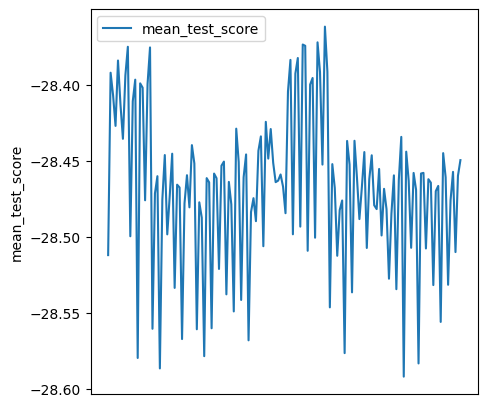

In [23]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()
df_plot_grid_rf.set_index("params")[["mean_test_score"]].plot(ax=ax)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)
ax.set_xlabel("grid_parameters")
ax.set_ylabel("mean_test_score")



*Now we get to print the MSE, MAE, RMSE and R<sup>2</sup> score*

In [8]:
y_pred = grid_search.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
print ('mse = {}, rmse = {} \nmae = {} r2 = {}'.format(mse,math.sqrt(mse), mae, r2))

mse = 804.825496216108, rmse = 28.369446526432412 
mae = 18.69819070870873 r2 = 0.5180905004097544


Now we compute Random Forest with the best params in order to save time as the GridSearch is quite time and resources consuming

In [24]:
rf_reg = RandomForestRegressor(bootstrap=True, 
                            max_depth=40,
                            max_features=90,
                            min_samples_leaf=4,
                            min_samples_split=16,
                            n_estimators=800)
rf_reg.fit(X_train, y_train)

rf_reg_pred = rf_reg.predict(X_test)

mse = metrics.mean_squared_error(y_test, rf_reg_pred)
mae = metrics.mean_absolute_error(y_test, rf_reg_pred)
r2 = metrics.r2_score(y_test, rf_reg_pred)
print ('mse = {}, rmse = {} \nmae = {} r2 = {}'.format(mse,math.sqrt(mse), mae, r2))

mse = 806.2002672145373, rmse = 28.39366596997537 
mae = 18.70984105757427 r2 = 0.5172673217119881
